In [6]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import yfinance as yf
import hvplot.pandas
from pathlib import Path
from finta import TA
import matplotlib.pyplot as plt
import quantstats as qs
import itertools
from IPython.display import clear_output

In [7]:
### Quant framework 3 x 3 x 3

#     Intraday   >>Swing<<    >>Position<<

#     Earnings     Event      >>TA<<

#   >>Delta<<      Theta        Vega

# Project 2 scope is focused on Swing and Position timeframe, while relying on TA
# to determine signals. Option strategies are not used.

### Technical goal:

# Automate creation and testing of new trading algorithms based on our framework

### Plan:

# 1. Pull the data: ohlc + volume ✓
# 2. Integrate Finta with our data ✓
# 3. Determine trading signals for testable indicators (crossovers, etc.)✓
# 4. Test the strategy on data of 2017 - 2019 
# 5. Automate testing of different combinations of strategies
# 6. Train ML algorithms on best performing strategies
# 7. Deploy trained ML algorithms and test performance on 2020-2023 data

In [8]:
sqrt = np.sqrt(252)
trading_days_year = 252
total_days_year = 365
thirty_years_ago = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year * 30)).date()
ten_years_ago = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year * 10)).date()
five_years_ago = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year * 5)).date()
three_years_ago = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year * 3)).date()
one_year = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year * 1)).date()
six_months = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year / 2)).date()
yesterday = (pd.Timestamp.today() - pd.Timedelta(days = 1)).date()
sixty_days = (pd.Timestamp.today() - pd.Timedelta(days = 59)).date()
# Portfolio vars

share_size = 100
initial_capital = 100000

# Optionable stocks 
optionable_stocks_path = Path('./Resources/optionable_stocks.csv')
with open(optionable_stocks_path, 'r') as file:
    optionable_stocks = file.read()
optionable_stocks = optionable_stocks.replace('\n', ' ')

In [9]:
optionable_stocks

'FCX GOLD NEM WPM X TMUS VZ ROKU SNAP SPOT T NFLX META DIS DISH ATVI AMZN DHI ETSY GM MGM NKE HD M SBUX TSLA WMT TGT MO KO PEP PG PM CAG BYND ADM APA CCJ CVX DVN MRO HAL MPC SLB OXY VLO MA MARA JPM PYPL MS GDXJ BX COF AXP C BAC AFL AMGN ABBV ABT BMY CAH CVS PFE JNJ MDT MRK MRNA WBA RTX LUV PLUG MMM GE CAT CSX DAL BA AAL AMT WELL ZM SQ AMD AAPL CRM MRVL NVDA ORCL QCOM MSFT MU HPQ INTC '

# 1. Pull the data: ohlc + volume

In [13]:
def get_data(interval, start, end):
    yf_df = yf.Tickers(optionable_stocks)
    df_full =yf_df.history(start = start, end = end, interval= interval)
    stocks = df_full[['Open', 'Close', 'High', 'Low', 'Volume']]
    return stocks

# 2. Integrate Finta with our data 

In [51]:
def get_individual_stock(stock, stocks):
    mask = stocks.columns.get_level_values(1) == stock
    data = stocks.loc[:, mask]
    data.columns = data.columns.droplevel(1)
    data.dropna(inplace = True)
    return data

## Getting indicators demo
### Once we have the finalized list of indicators, I will combine them into one function

In [15]:
# EMA
short_window = 8
long_window = 21
df = get_individual_stock('TSLA')
df[f'EMA_{short_window}'] = TA.EMA(df, short_window)
df[f'EMA_{long_window}'] = TA.EMA(df, long_window)
df[['Close', 'EMA_8', 'EMA_21']].plot(figsize = (25,7))

TypeError: get_individual_stock() missing 1 required positional argument: 'stocks'

In [16]:
# BBANDS
df = get_individual_stock('TSLA')
df[['BB_UPPER','BB_MIDDLE','BB_LOWER']] = TA.BBANDS(df)
df[['Close', 'BB_UPPER','BB_MIDDLE','BB_LOWER']].plot(figsize = (25,7))

# Keltner Channels
df = get_individual_stock('TSLA')
df[['KC_UPPER', 'KC_LOWER']] = TA.KC(df)
df[['Close', 'KC_UPPER', 'KC_LOWER']].plot(figsize = (25,7))

TypeError: get_individual_stock() missing 1 required positional argument: 'stocks'

In [ ]:
# ADX
df = get_individual_stock('TSLA')
df['ADX'] = TA.ADX(df)
df[['Close','ADX']].plot(figsize = (25,7))

In [ ]:
# MACD
df = get_individual_stock('TSLA')
df[['MACD', 'SIGNAL']] = TA.MACD(df)

df[['MACD', 'SIGNAL']].plot(figsize = (25,7))


In [ ]:
df = get_individual_stock('TSLA')
df[['TENKAN','KIJUN','senkou_span_a','SENKOU','CHIKOU']] = TA.ICHIMOKU(df)
df

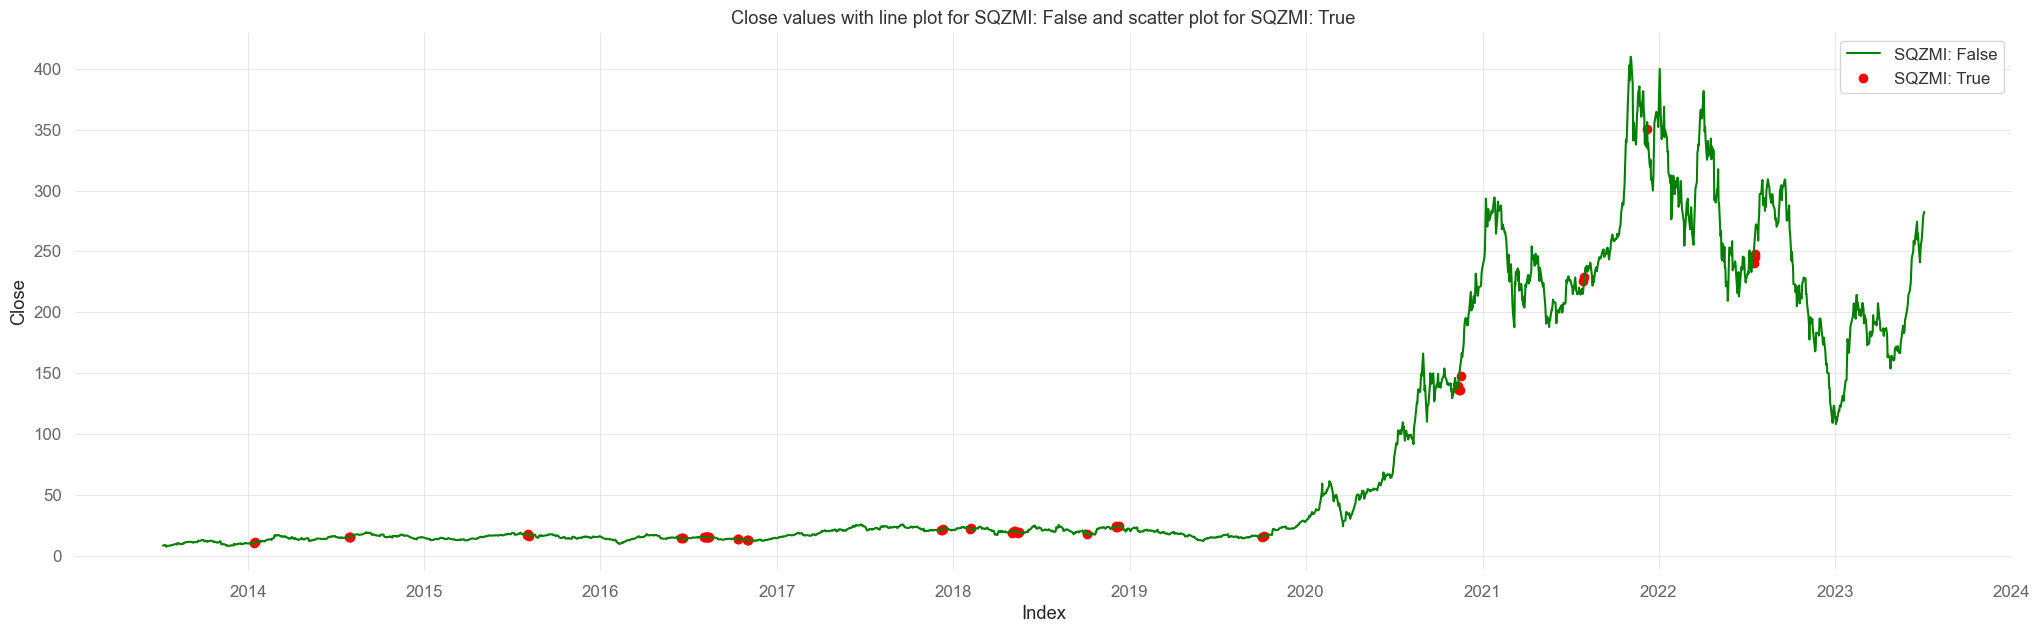

In [305]:
df = get_individual_stock('TSLA', stocks = stocks)
df['SQZMI'] = TA.SQZMI(df)
# Filter the DataFrame based on SQZMI values
false_df = df[df['SQZMI'] == False]
true_df = df[df['SQZMI'] == True]

# Extract the Close values
false_close_values = false_df['Close']
true_close_values = true_df['Close']

# Set the figure size
plt.figure(figsize=(25, 7))  # Adjust the width and height as desired

# Plot the values
plt.plot(false_close_values, color='green', label='SQZMI: False')
plt.scatter(true_df.index, true_close_values, color='red', label='SQZMI: True')
plt.xlabel('Index')
plt.ylabel('Close')
plt.title("Close values with line plot for SQZMI: False and scatter plot for SQZMI: True")
plt.legend()
plt.show()

In [ ]:
TA.RSI(df, period = 21)

# 3. Determine trading signals for testable indicators (crossovers, etc.)

# Iterator Class

In [273]:
stocks = get_data('1d', ten_years_ago, yesterday)
stock_names = stocks.columns.get_level_values(1).unique().tolist()
#res_all_1d = Tester(stocks_df= stocks, interval = '1d', stock_list= stock_names)

[*********************100%***********************]  95 of 95 completed


In [303]:
# Define a class
class SignalIterator:
    
    def __init__(self, ticker, interval, stocks_df, share_size = 100, initial_cash = 10000):
        
        if interval == '5m':
            self.sqrt_val = 252 * 78 
        elif interval == '15m':
            self.sqrt_val = 252 * 26  
        elif interval == '30m':
            self.sqrt_val = 252 * 13 
        elif interval == '1h':
            self.sqrt_val = 252 * 6.5
        elif interval == '1d':
            self.sqrt_val = 252
            
        print(self.sqrt_val)
            
        self.stocks_df = stocks_df
        self.interval = interval
        self.ticker = ticker
        self.share_size = share_size
        self.initial_cash = initial_cash
        
        # Call the basic methods in the __init__ constructor to be immediately executed
        
        self.get_individual_stock()
        self.indicators()
        self.signals()

    def get_individual_stock(self):
        mask = self.stocks_df.columns.get_level_values(1) == self.ticker
        self.df = self.stocks_df.loc[:, mask]
        self.df.columns = self.df.columns.droplevel(1)
        self.df.dropna(inplace = True, axis = 0)
        
    def indicators(self):
        
        # EMA
        self.df['EMA_10'] = TA.EMA(self.df, 10)
        
        # EMA
        self.df['EMA_20'] = TA.EMA(self.df, 20)
        
         # EMA
        self.df['EMA_50'] = TA.EMA(self.df, 50)
        
        # BBANDS
        self.df[['BB_UPPER','BB_MIDDLE','BB_LOWER']] = TA.BBANDS(self.df, std_multiplier= 3)
        
        # SQZ setup
        self.df['SQZ'] = TA.SQZMI(self.df)
        
        # ADX
        self.df['ADX'] = TA.ADX(self.df)
        
        # MACD
        self.df[['MACD', 'SIGNAL']] = TA.MACD(self.df)
        
        # CHAIKIN
        self.df['CHAIKIN'] = TA.CHAIKIN(self.df)
        
        # MFI
        self.df['MFI'] = TA.MFI(self.df)
   
    def signals(self):
        
        ### BUY SIGNALS ###
        
        # EMA Signal logic
        self.df['EMA20_Signal'] = 0.0
        self.df['EMA20_Signal'] = np.where((self.df['Close'] > self.df['EMA_20']), 1.0, 0.0)
        
        # EMA Signal logic
        self.df['EMA50_Signal'] = 0.0
        self.df['EMA50_Signal'] = np.where((self.df['Close'] > self.df['EMA_50']), 1.0, 0.0)
        
        # SQZ Signal logic
        self.df['SQZ_Signal'] = 0.0
        self.df['SQZ_Signal'] = np.where(self.df['SQZ'] == False, 1.0, 0.0)
        
        # ADX Signal logic
        self.df['ADX_Signal'] = 0.0
        self.df['ADX_Signal'] = np.where(self.df['ADX'] > 30, 1.0, 0.0)
        
        # MACD Signal logic
        self.df['MACD_Signal'] = 0.0
        self.df['MACD_Signal'] = np.where(self.df['MACD'] > self.df['SIGNAL'], 1.0, 0.0)        
        
        # CHAIKIN Signal logic
        self.df['CHAIKIN_Signal'] = 0.0
        self.df['CHAIKIN_Signal'] = np.where(self.df['CHAIKIN'] > 0, 1.0, 0.0)        
        
        # MFI Signal logic
        self.df['MFI_Signal'] = 0.0
        self.df['MFI_Signal'] = np.where(self.df['MFI'] < 20, 1.0, 0.0)    
        
        ### SELL SIGNALS ###
        
        # BBANDS Sell Signal Logic
        self.df['BB_Sell_Signal'] = 0.0
        self.df['BB_Sell_Signal'] = np.where((self.df['Close'] > self.df['BB_UPPER']), 0.0, 1.0)        
        
    def result(self):
        
        # Define eval df columns
        columns = ['Buy Signals', 'Sell Signals', 'Annualized Return', 'Cumulative Return', 'Annual Volatility', 'Sharpe Ratio']
        eval_df = pd.DataFrame( columns= columns)
        # Define the signal column names
        buy_signal_columns = ['EMA50_Signal','SQZ_Signal','ADX_Signal','CHAIKIN_Signal','MFI_Signal']
        sell_signal_columns = ['BB_Sell_Signal','EMA20_Signal', 'MACD_Signal','ADX_Signal']
        # Generate all combinations of signal columns
        for r_buy in range(1, len(buy_signal_columns) + 1):
            combinations_buy = list(itertools.combinations(buy_signal_columns, r_buy))

            # Generate all combinations of sell signal columns
            for r_sell in range(1, len(sell_signal_columns) + 1):
                combinations_sell = list(itertools.combinations(sell_signal_columns, r_sell))

                # Iterate over each combination of buy and sell signals
                for combo_buy in combinations_buy:
                    selected_buy_columns = list(combo_buy)

                    for combo_sell in combinations_sell:
                        selected_sell_columns = list(combo_sell)

                        # Initialize the first row of Main_Signal as 0
                        self.df['Main_Signal'] = 0.0

                        # Iterate over the remaining rows
                        for i in range(1, self.df.shape[0]):
                            previous_signal = self.df['Main_Signal'].iloc[i - 1]

                            if previous_signal == 0:
                                # Use Buy Signals to determine current signal
                                buy_signal_conditions = (self.df.loc[self.df.index[i], buy_signal_columns] == 1).all()
                                sell_signal_conditions = (self.df.loc[self.df.index[i], sell_signal_columns] == 1).all()
                                self.df['Main_Signal'].iloc[i] = int(buy_signal_conditions and sell_signal_conditions)

                            else:
                                # Use Sell Signals to determine current signal
                                sell_signal_conditions = (self.df.loc[self.df.index[i], sell_signal_columns] == 0).all()
                                self.df['Main_Signal'].iloc[i] = int(sell_signal_conditions)
                        print(f'{selected_buy_columns} + {selected_sell_columns} complete')

                        # Entry/Exit logic
                        self.df['Entry/Exit'] = self.df['Main_Signal'].diff()

                        # Performance Metrics
                        self.df["Position"] = self.share_size * self.df['Main_Signal']
                        self.df["Entry/Exit Position"] = self.df["Position"].diff()
                        self.df["Portfolio Holdings"] = self.df["Position"] * self.df['Close']
                        self.df["Portfolio Cash"] = self.initial_cash - (self.df['Close'] * self.df['Entry/Exit Position']).cumsum()
                        self.df["Portfolio Total"] = self.df["Portfolio Cash"] + self.df["Portfolio Holdings"]
                        self.df["Portfolio Daily Returns"] = self.df["Portfolio Total"].pct_change()
                        self.df["Portfolio Cumulative Returns"] = (1 + self.df["Portfolio Daily Returns"]).cumprod()
                        self.df['Buy And Hold Return'] = (1 + self.df["Close"].pct_change()).cumprod()

                        # Create a df with performance summary for each combination

                        # append evaluation metrics to a df as a new row
                        ann_ret =  self.df['Portfolio Daily Returns'].mean() * self.sqrt_val
                        cum_ret = self.df['Portfolio Cumulative Returns'][-1]
                        ann_volat = self.df['Portfolio Daily Returns'].std() * np.sqrt(self.sqrt_val)
                        sharpe = ann_ret / ann_volat
                        buy_and_hold = self.df['Buy And Hold Return'][-1]
                        new_row = {'Buy Signals' : f'{selected_buy_columns}',
                                   'Sell Signals' : f'{selected_sell_columns}',
                                   'Annualized Return' : ann_ret,
                                   'Cumulative Return' : cum_ret,
                                   'Annual Volatility' : ann_volat,
                                   'Sharpe Ratio' : sharpe,
                                   'Buy and Hold': buy_and_hold,
                                   'Ticker': self.ticker}
                        eval_df = eval_df.append(new_row, ignore_index=True)

        self.filtered_df = eval_df[eval_df['Cumulative Return'] > 1].sort_values('Cumulative Return', ascending = False)
        self.filtered_df['Beat Buy and Hold?'] = np.where(self.filtered_df['Cumulative Return'] > self.filtered_df['Buy and Hold'], True, False)        
        return self.filtered_df 

    def plot_top_strategy(self):
        top_5_strategies = self.filtered_df.head(5)

        # Iterate over each row in the top 5 strategies
        for index, row in top_5_strategies.iterrows():
            # Create a new figure for each strategy
            plt.figure(figsize=(25, 10))

            # Get the strategy name
            ticker = row['Ticker']
            selected_buy_columns = eval(row['Buy Signals'])
            selected_sell_columns = eval(row['Sell Signals'])

            # Check if all buy signal columns are 1
            buy_signal = (self.df[selected_buy_columns] == 1).all(axis=1)

            # Check if all sell signal columns are 0
            sell_signal = (self.df[selected_sell_columns] == 0).all(axis=1)

            # Generate the main signal based on buy and sell signals
            self.df['Main_Signal'] = buy_signal.astype(int) * sell_signal.astype(int)

            # Entry/Exit logic
            self.df['Entry/Exit'] = self.df['Main_Signal'].diff()

            # Performance Metrics
            self.df["Position"] = self.share_size * self.df['Main_Signal']
            self.df["Entry/Exit Position"] = self.df["Position"].diff()
            self.df["Portfolio Holdings"] = self.df["Position"] * self.df['Close']
            self.df["Portfolio Cash"] = self.initial_cash - (self.df['Close'] * self.df['Entry/Exit Position']).cumsum()
            self.df["Portfolio Total"] = self.df["Portfolio Cash"] + self.df["Portfolio Holdings"]
            self.df["Portfolio Daily Returns"] = self.df["Portfolio Total"].pct_change()
            self.df["Portfolio Cumulative Returns"] = (1 + self.df["Portfolio Daily Returns"]).cumprod()
            self.df['Buy And Hold Return'] = (1 + self.df["Close"].pct_change()).cumprod()

            # Get the entry/exit signal
            entry_exit = self.df['Entry/Exit']

            portfolio_cumulative_returns = self.df["Portfolio Cumulative Returns"]
            # Plot the portfolio cumulative returns
            plt.plot(portfolio_cumulative_returns, label=f'{ticker} : {selected_buy_columns} & {selected_sell_columns}')

            # Plot the entry/exit points with markers
            plt.plot(entry_exit[entry_exit == 1].index, portfolio_cumulative_returns[entry_exit == 1], 'gv', markersize=15)  # Green markers for entry
            plt.plot(entry_exit[entry_exit == -1].index, portfolio_cumulative_returns[entry_exit == -1], 'r^', markersize=15)  # Red markers for exit

            # Set the plot title and labels
            plt.title("Strategy - Portfolio Cumulative Returns")
            plt.xlabel("Time")
            plt.ylabel("Cumulative Returns")
            plt.legend()

            # Show the plot for the current strategy
            plt.show()


In [302]:
# Class that tests the model on our list of stocks

class Tester:
    
    def __init__(self, interval, stocks_df, stock_list):
        
        self.stock_list = stock_list
        self.interval = interval
        self.stocks_data = stocks_df
        
        
        self.backtest_on_stocks()
        self.top_return()
        self.top_sharpe()
        self.beat_bnh()
        
    def backtest_on_stocks(self):
        self.combined = pd.DataFrame()
        for index, stock in enumerate(self.stock_list):
            self.iterator = SignalIterator(stock, interval = self.interval, stocks_df = self.stocks_data)
            result = self.iterator.result()
            self.combined = pd.concat([self.combined, result], axis=0)
            clear_output(wait=True)
            print(f'{stock} analysis complete ({index+1}/{len(self.stock_list)})')
    
    def top_return(self):
        return self.combined.sort_values('Cumulative Return', ascending= False).head(50)
    
    def top_sharpe(self):
        return self.combined.sort_values('Sharpe Ratio', ascending= False).head(50)
    
    def beat_bnh(self):
        return self.combined[self.combined['Beat Buy and Hold?'] == True].sort_values('Cumulative Return', ascending= False).head(50)
    def plot_top(self):
        self.iterator.plot_top_strategy()

In [289]:
res_all = Tester(stocks_df= stocks, interval = '1d', stock_list= ['TSLA'])
res_all.top_return()

252
['EMA50_Signal'] + ['BB_Sell_Signal'] complete
['EMA50_Signal'] + ['EMA20_Signal'] complete
['EMA50_Signal'] + ['MACD_Signal'] complete
['EMA50_Signal'] + ['ADX_Signal'] complete
['SQZ_Signal'] + ['BB_Sell_Signal'] complete
['SQZ_Signal'] + ['EMA20_Signal'] complete
['SQZ_Signal'] + ['MACD_Signal'] complete
['SQZ_Signal'] + ['ADX_Signal'] complete
['ADX_Signal'] + ['BB_Sell_Signal'] complete
['ADX_Signal'] + ['EMA20_Signal'] complete
['ADX_Signal'] + ['MACD_Signal'] complete
['ADX_Signal'] + ['ADX_Signal'] complete
['CHAIKIN_Signal'] + ['BB_Sell_Signal'] complete
['CHAIKIN_Signal'] + ['EMA20_Signal'] complete
['CHAIKIN_Signal'] + ['MACD_Signal'] complete
['CHAIKIN_Signal'] + ['ADX_Signal'] complete
['MFI_Signal'] + ['BB_Sell_Signal'] complete
['MFI_Signal'] + ['EMA20_Signal'] complete
['MFI_Signal'] + ['MACD_Signal'] complete
['MFI_Signal'] + ['ADX_Signal'] complete
['EMA50_Signal'] + ['BB_Sell_Signal', 'EMA20_Signal'] complete
['EMA50_Signal'] + ['BB_Sell_Signal', 'MACD_Signal'] c

KeyboardInterrupt: 

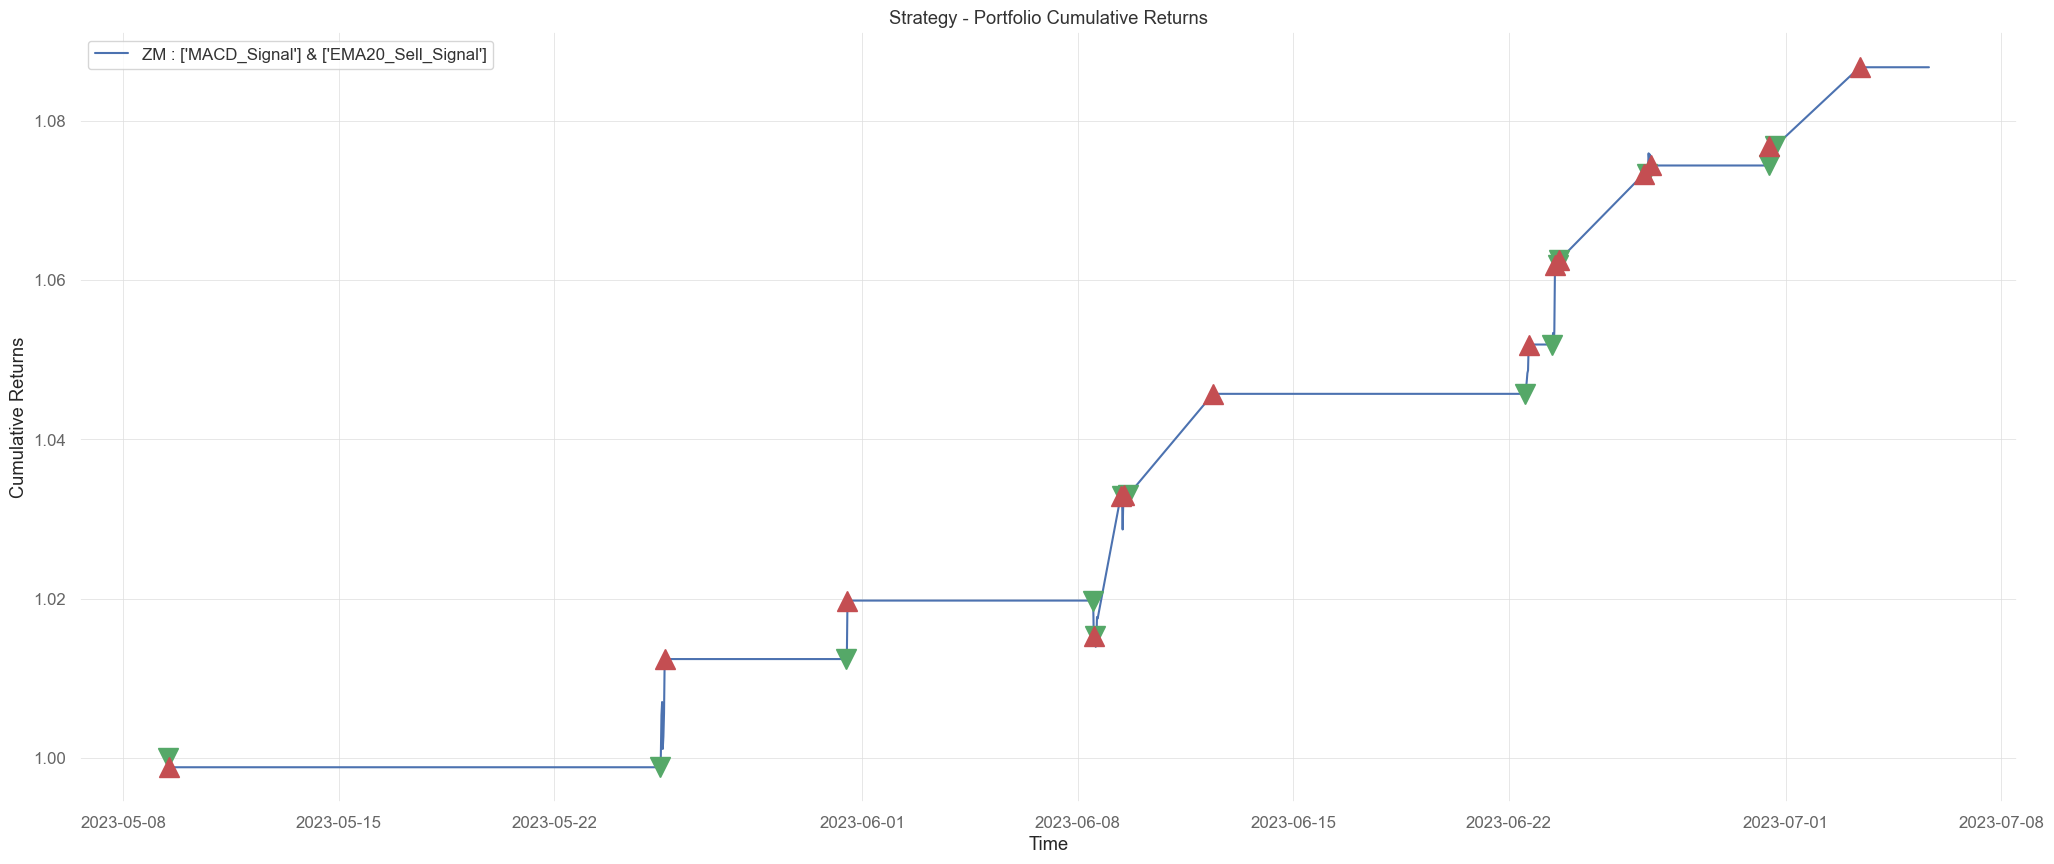

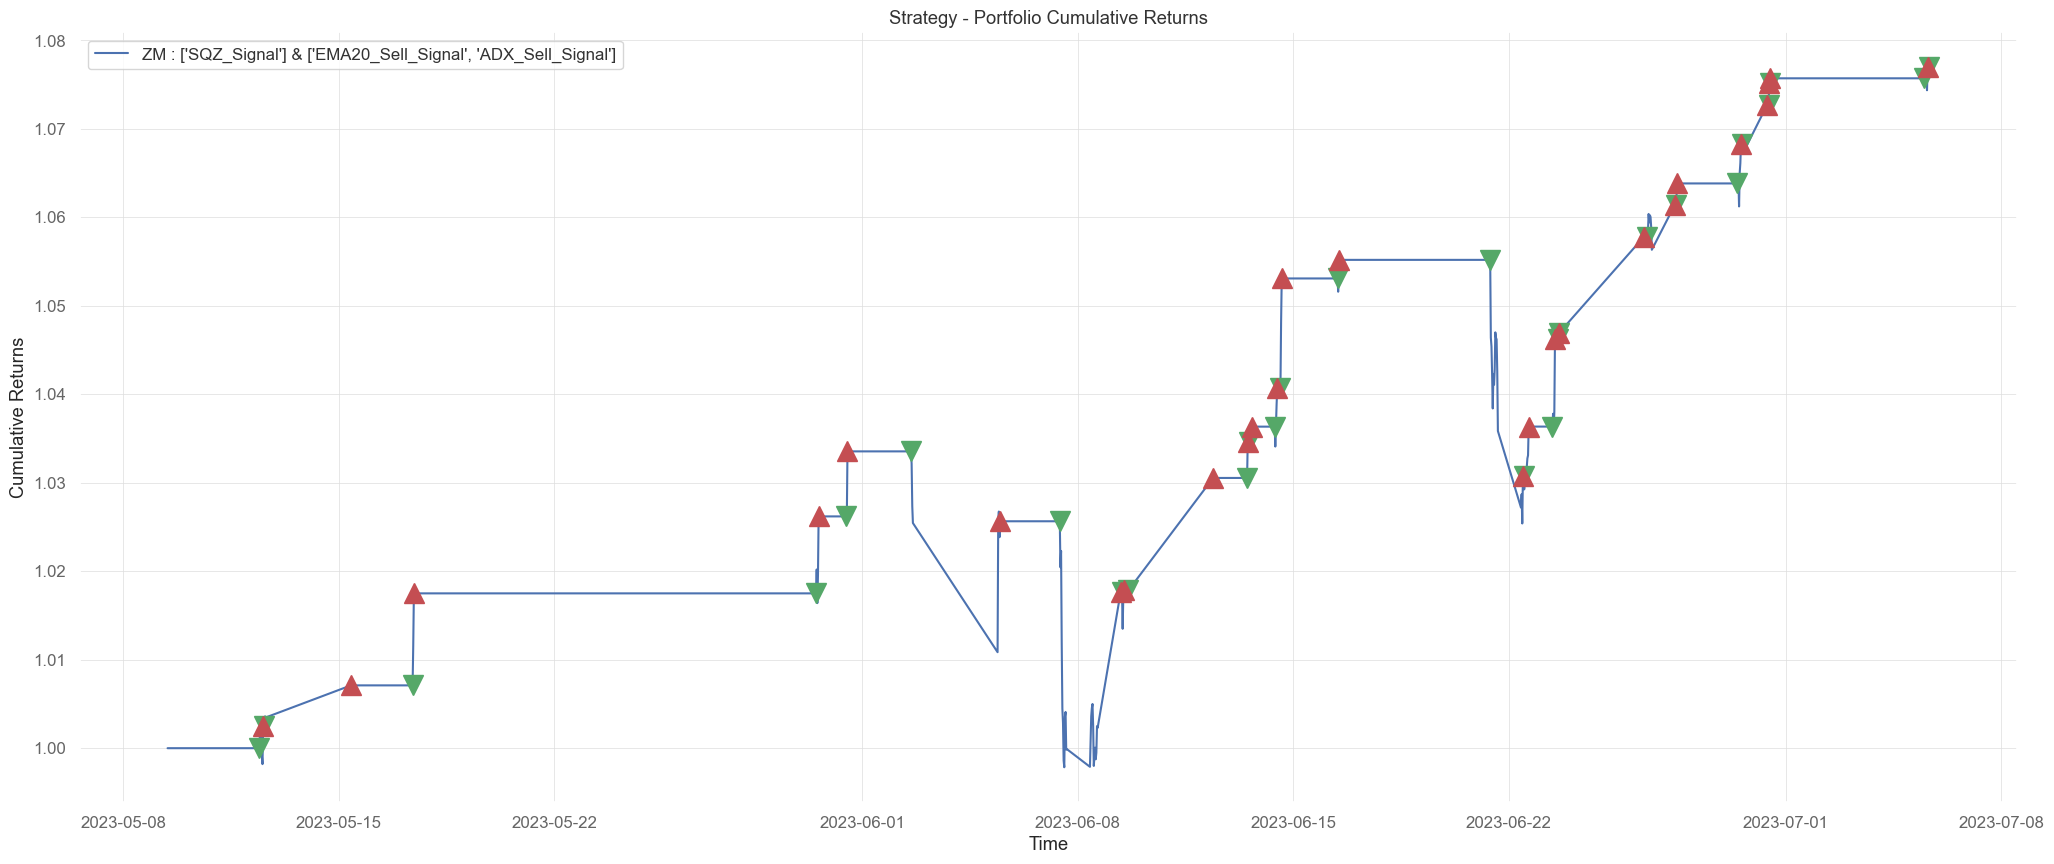

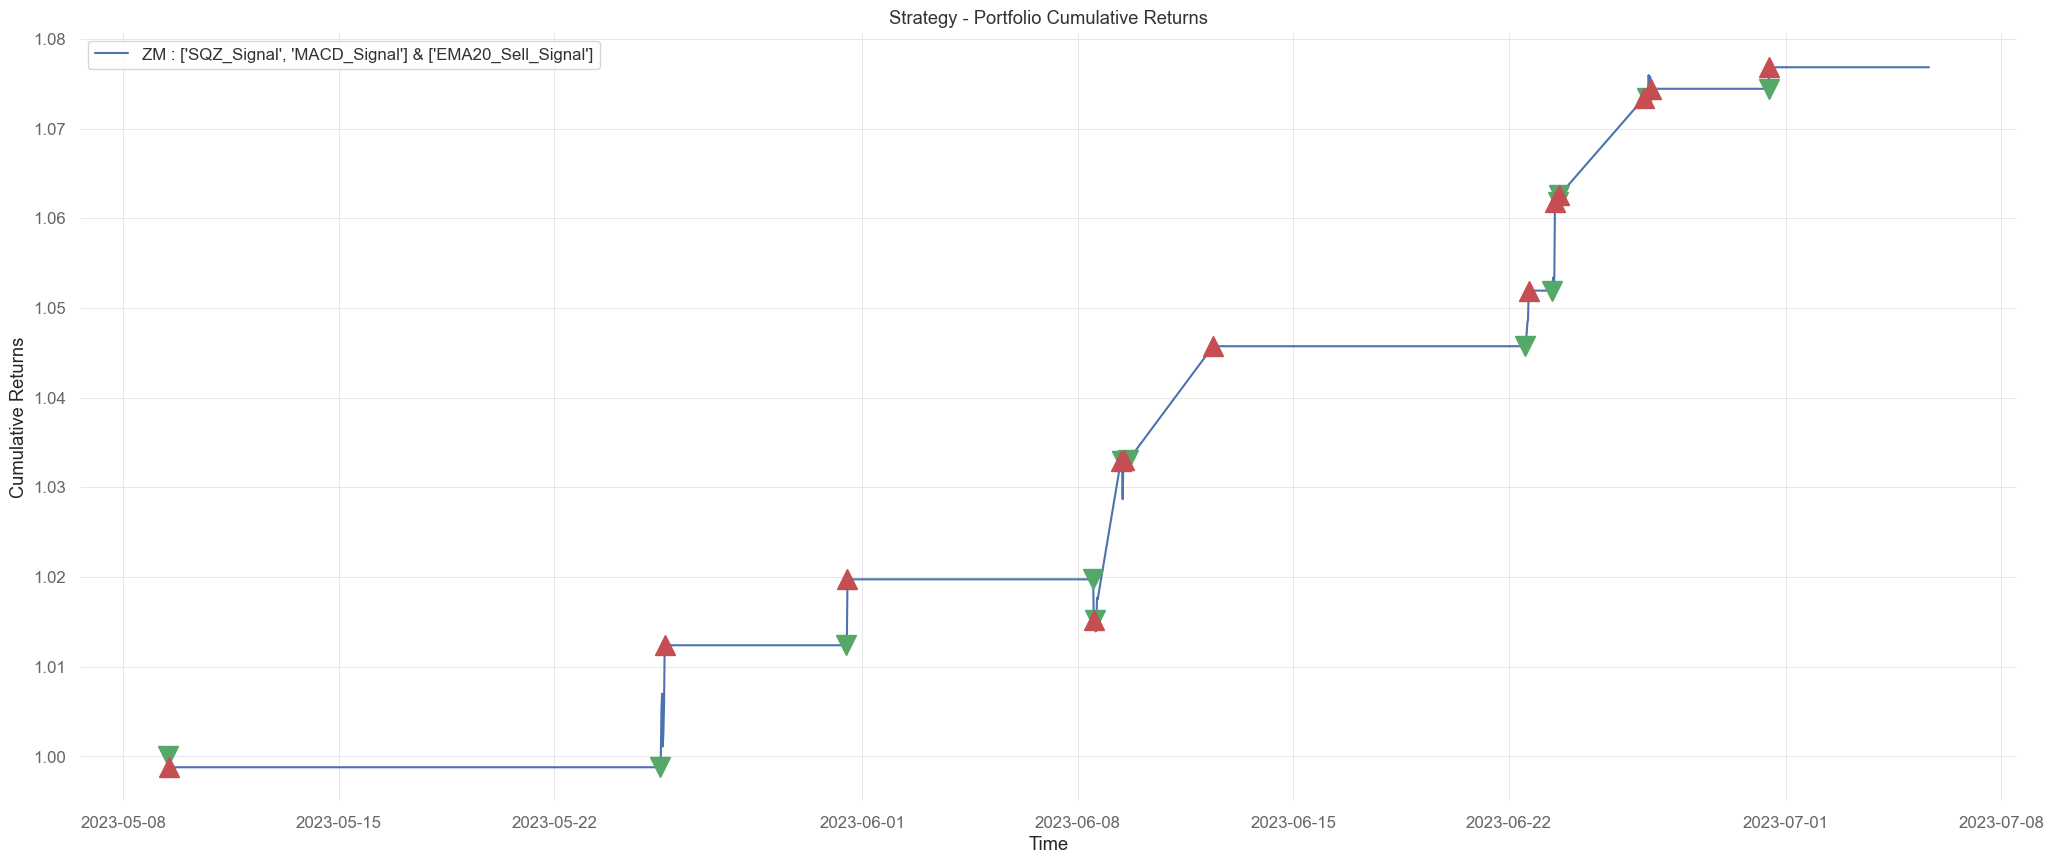

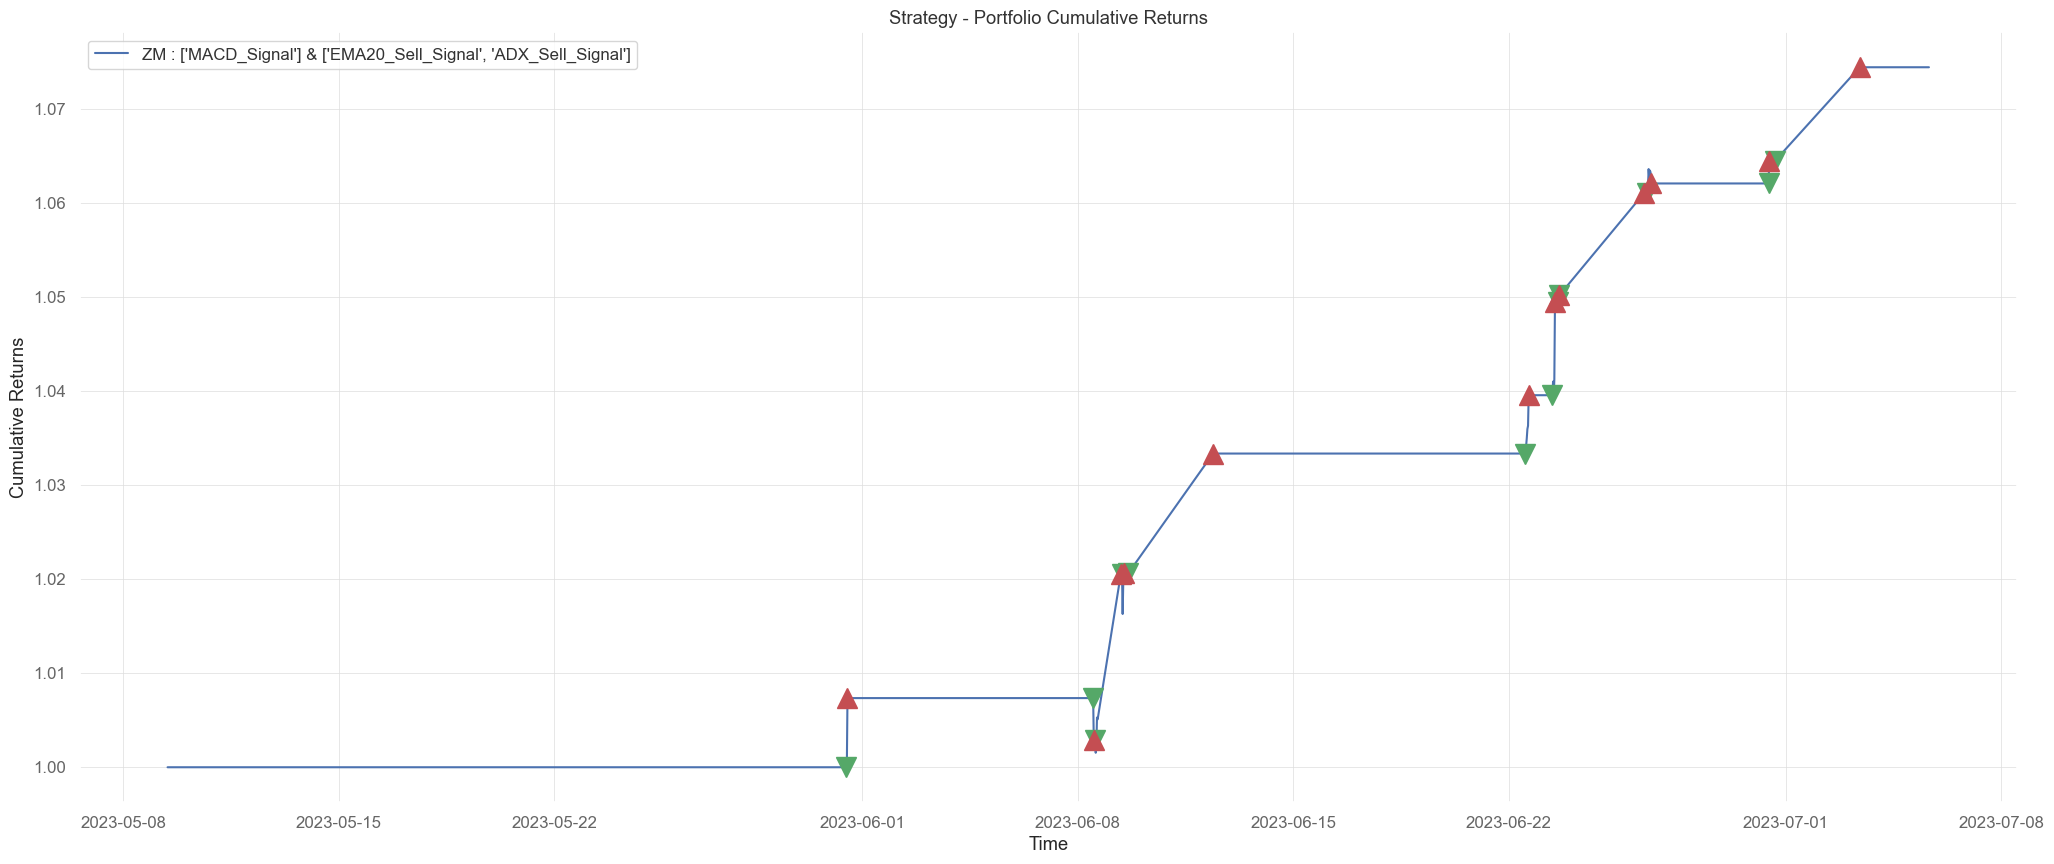

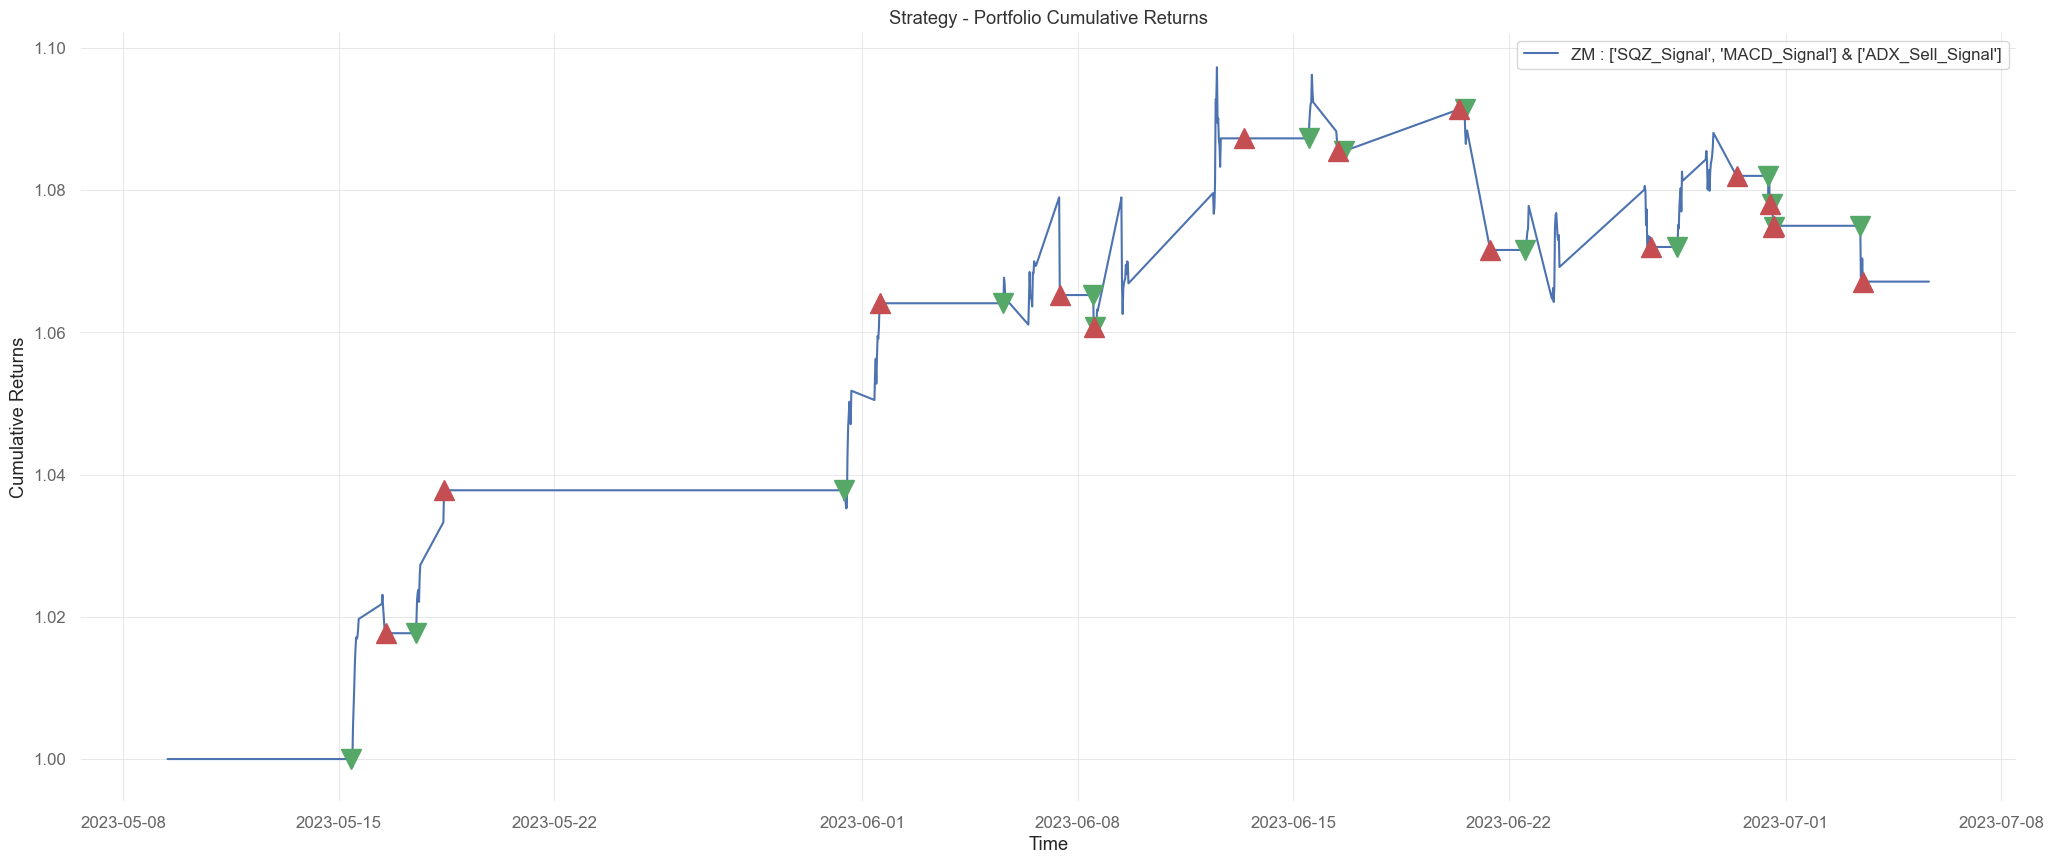

In [45]:
res_all.plot_top()

In [414]:
# Define a class
class BespokeStrategy:
    
    def __init__(self, ticker, interval, stocks_df, share_size = 100, initial_cash = 100000):
        
        if interval == '5m':
            self.sqrt_val = 252 * 78 
        elif interval == '15m':
            self.sqrt_val = 252 * 26  
        elif interval == '30m':
            self.sqrt_val = 252 * 13 
        elif interval == '1h':
            self.sqrt_val = 252 * 6.5
        elif interval == '1d':
            self.sqrt_val = 252
            
        print(self.sqrt_val)
            
        self.stocks_df = stocks_df
        self.interval = interval
        self.ticker = ticker
        self.share_size = share_size
        self.initial_cash = initial_cash
        
        # Call the basic methods in the __init__ constructor to be immediately executed
        
        self.get_individual_stock()
        self.indicators()
        self.signals()

    def get_individual_stock(self):
        mask = self.stocks_df.columns.get_level_values(1) == self.ticker
        self.df = self.stocks_df.loc[:, mask]
        self.df.columns = self.df.columns.droplevel(1)
        self.df.dropna(inplace = True, axis = 0)
        
    def indicators(self):
        
        ### BUY INDICATORS ###
        
        # MACD
        self.df[['MACD', 'SIGNAL']] = TA.MACD(self.df)
        
        # Rolling return window
        self.df['Returns'] = self.df['Close'].pct_change()
        self.df['60_Day_Return'] = (self.df['Returns'] + 1).rolling(window=60).apply(lambda x: x.prod(), raw=True)
        
        # SQZ
        self.df['SQZ'] = TA.SQZMI(self.df)
        
        ### SELL INDICATORS ###
        
        # EMA
        self.df['EMA_20'] = TA.EMA(self.df, 20)
        # ADX
        self.df['ADX'] = TA.ADX(self.df)
   
    def signals(self):
        
        ### BUY SIGNALS ###
        

        
        # 60 day return lookback window
        self.df['60_Day_Return_Signal'] = 0.0
        self.df['60_Day_Return_Signal'] = np.where(self.df['60_Day_Return'] > 0.50, 1.0, 0.0)
        
        # EMA Signal logic
        self.df['EMA20_Signal'] = 0.0
        self.df['EMA20_Signal'] = np.where(self.df['Close'] > self.df['EMA_20'], 1.0, 0.0)      
        
        # SQZ Signal logic
        self.df['SQZ_Signal'] = 0.0
        self.df['SQZ_Signal'] = np.where(self.df['SQZ'] == True, 1.0, 0.0)
        
        # MACD Signal logic
        self.df['MACD_Signal'] = 0.0
        self.df['MACD_Signal'] = np.where(self.df['MACD'] > self.df['SIGNAL'], 1.0, 0.0) 
        
        ### SELL SIGNALS ### 
        
        # ADX Signal logic
        self.df['ADX_Sell_Signal'] = 0.0
        self.df['ADX_Sell_Signal'] = np.where(self.df['ADX'] <= 30, 0.0, 1.0)        

        
    def result(self):
        
        # Define eval df columns
        columns = ['Buy Signals', 'Sell Signals', 'Annualized Return', 'Cumulative Return', 'Annual Volatility', 'Sharpe Ratio']
        self.eval_df = pd.DataFrame( columns= columns)
        # Define the signal column names
        buy_signal_columns = ['MACD_Signal']
        sell_signal_columns = ['MACD_Signal']
        
        # Initialize the first row of Main_Signal as 0
        self.df['Main_Signal'] = 0.0

        # Iterate over the remaining rows
        for i in range(1, self.df.shape[0]):
            previous_signal = self.df['Main_Signal'].iloc[i - 1]

            if previous_signal == 0:
                # Use Buy Signals to determine current signal
                buy_signal_conditions = (self.df.loc[self.df.index[i], buy_signal_columns] == 1).all()
                sell_signal_conditions = (self.df.loc[self.df.index[i], sell_signal_columns] == 1).all()
                self.df['Main_Signal'].iloc[i] = int(buy_signal_conditions and sell_signal_conditions)
                
            else:
                # Use Sell Signals to determine current signal
                sell_signal_conditions = (self.df.loc[self.df.index[i], sell_signal_columns] == 1).all()
                self.df['Main_Signal'].iloc[i] = int(sell_signal_conditions)
        
        # Entry/Exit logic
        self.df['Entry/Exit'] = self.df['Main_Signal'].diff()


        # Performance Metrics
        self.df["Position"] = self.share_size * self.df['Main_Signal']
        self.df["Entry/Exit Position"] = self.df["Position"].diff()
        self.df["Portfolio Holdings"] = self.df["Position"] * self.df['Close']
        self.df["Portfolio Cash"] = self.initial_cash - (self.df['Close'] * self.df['Entry/Exit Position']).cumsum()
        self.df["Portfolio Total"] = self.df["Portfolio Cash"] + self.df["Portfolio Holdings"]
        self.df["Portfolio Daily Returns"] = self.df["Portfolio Total"].pct_change()
        self.df["Portfolio Cumulative Returns"] = (1 + self.df["Portfolio Daily Returns"]).cumprod()
        self.df['Buy And Hold Return'] = (1 + self.df["Close"].pct_change()).cumprod()

        # Create a df with performance summary for each combination

        # append evaluation metrics to a df as a new row
        ann_ret =  self.df['Portfolio Daily Returns'].mean() * self.sqrt_val
        cum_ret = self.df['Portfolio Cumulative Returns'].iloc[-1]
        ann_volat = self.df['Portfolio Daily Returns'].std() * np.sqrt(self.sqrt_val)
        sharpe = ann_ret / ann_volat
        buy_and_hold = self.df['Buy And Hold Return'].iloc[-1]
        new_row = {'Buy Signals' : f'{buy_signal_columns}',
                   'Sell Signals' : f'{sell_signal_columns}',
                   'Annualized Return' : ann_ret,
                   'Cumulative Return' : cum_ret,
                   'Annual Volatility' : ann_volat,
                   'Sharpe Ratio' : sharpe,
                   'Buy and Hold': buy_and_hold,
                   'Ticker': self.ticker}
        self.eval_df = self.eval_df.append(new_row, ignore_index=True)
        self.eval_df['Beat Buy and Hold?'] = np.where(self.eval_df['Cumulative Return'] > self.eval_df['Buy and Hold'], True, False)     
        
        return self.eval_df

    def plot_strategy(self):

        # Create a new figure for each strategy
        plt.figure(figsize=(25, 10))
        
        # Get the entry/exit signal
        entry_exit = self.df['Entry/Exit']
        bnh = self.df['Buy And Hold Return']
        close = self.df['Close']
        ema = self.df['EMA_20']
        
        portfolio_cumulative_returns = self.df['Portfolio Daily Returns']
        
        # Plot the portfolio cumulative returns
        plt.plot(bnh, label=f'{self.ticker} Cumulative Return')
        plt.plot(portfolio_cumulative_returns, label='Portfolio Cumulative Returns')
        
        # Plot the entry points as vertical lines
        for entry_index in entry_exit[entry_exit == 1].index:
            plt.axvline(entry_index, color='g', linestyle='--')

        # Plot the exit points as vertical lines
        for exit_index in entry_exit[entry_exit == -1].index:
            plt.axvline(exit_index, color='r', linestyle='--')

        # Set the plot title and labels
        plt.title("Strategy - Entry/Exits")
        plt.xlabel("Time")
        plt.ylabel("Price")
        plt.legend()

        # Show the plot for the current strategy
        plt.show()


In [417]:
stocks = get_data('1d', ten_years_ago, yesterday)


[*********************100%***********************]  95 of 95 completed


In [422]:
tailored_strategy = BespokeStrategy('NFLX', '1d', stocks )
tailored_strategy.result()

252


,Buy Signals,Sell Signals,Annualized Return,Cumulative Return,Annual Volatility,Sharpe Ratio,Buy and Hold,Ticker,Beat Buy and Hold?
0,['MACD_Signal'],['MACD_Signal'],0.022466,1.219056,0.072166,0.311309,12.61743,NFLX,False


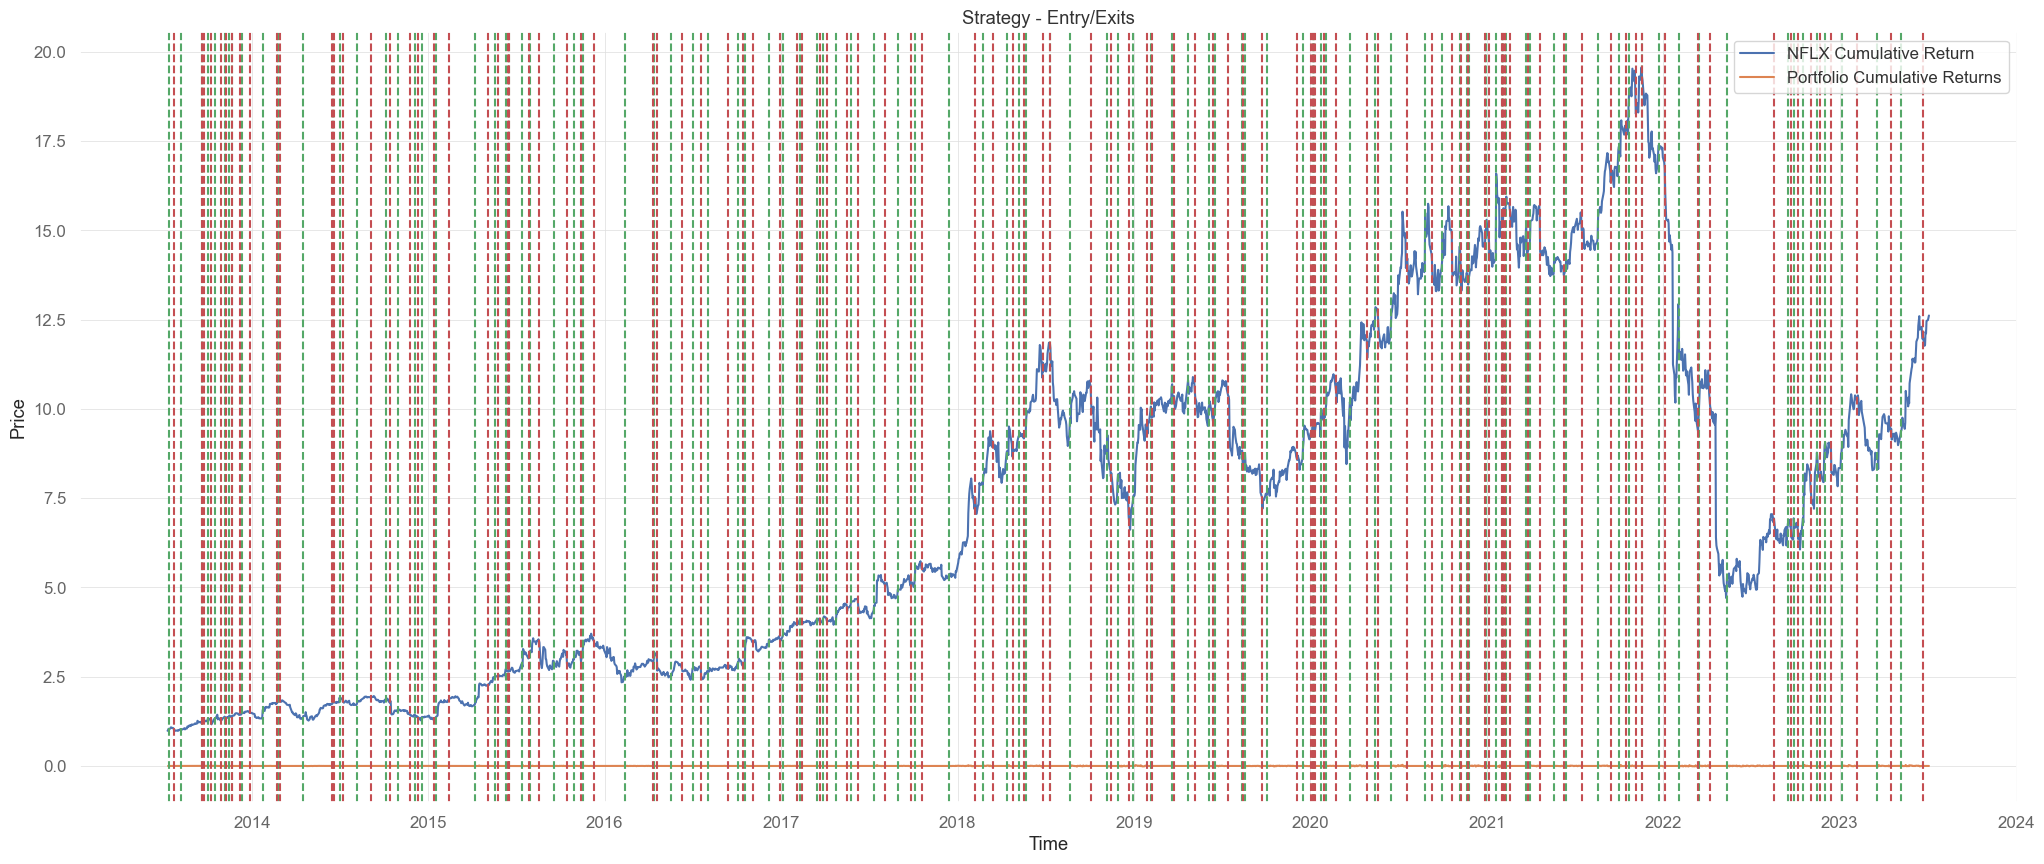

In [423]:
tailored_strategy.plot_strategy()